# Topic modeling with tmtoolkit

Adapted from: https://github.com/WZBSocialScienceCenter/tmtoolkit/blob/master/doc/source/topic_modeling.ipynb

## An example document-term matrix

tmtoolkit supports topic models that are computed from document-term matrices (DTMs).

In [1]:
import random
import os
import logging
import warnings
import numpy as np

try:
    import tmtoolkit
except ModuleNotFoundError:
    !pip install tmtoolkit[recommended,lda,sklearn,gensim]
from tmtoolkit.topicmod import tm_lda
from tmtoolkit.topicmod.model_io import print_ldamodel_topic_words
from tmtoolkit.topicmod.tm_lda import compute_models_parallel
from tmtoolkit.topicmod.tm_lda import evaluate_topic_models
from tmtoolkit.topicmod.evaluate import results_by_parameter
from tmtoolkit.corpus import Corpus
from tmtoolkit.preprocess import TMPreproc

In [2]:
random.seed(20191120)   # to make the sampling reproducible
np.set_printoptions(precision=5)

DATADIR = '../../data/documenters/illinois'
_corpus = Corpus()


def documents(datadir=DATADIR):
    for fn in os.listdir(datadir):
        yield fn, open(os.path.join(datadir, fn)).read()

for fn, text in documents():
    _corpus.add_doc(fn[:-4], text)

_corpus

<Corpus [17237 documents]>

(array([1.6794e+04, 2.8100e+02, 1.0700e+02, 3.6000e+01, 1.3000e+01,
        4.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([      0. ,  217464.5,  434929. ,  652393.5,  869858. , 1087322.5,
        1304787. , 1522251.5, 1739716. , 1957180.5, 2174645. ]),
 <a list of 10 Patch objects>)

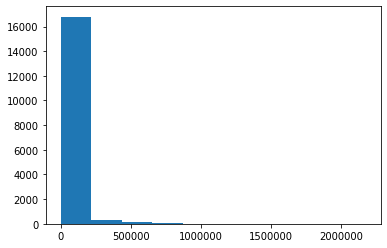

In [3]:
import matplotlib

matplotlib.pyplot.hist(_corpus.doc_lengths.values())

In [4]:
from statistics import mean, stdev
doclen_mean = mean(_corpus.doc_lengths.values())
doclen_std = stdev(_corpus.doc_lengths.values())
print('Mean doc length:', doclen_mean)
print('Std:', doclen_std)

Mean doc length: 27797.95039740094
Std: 79844.54599522066


In [5]:
# For topic modeling, document sizes should be similar.
# If there is a lot of variance, we might look at a subset of documents of similar size
_corpus = _corpus.filter_by_max_length(doclen_mean + doclen_std)
_corpus

<Corpus [16279 documents]>

In [6]:
try:
    import nltk
except ModuleNotFoundError:
    !pip install nltk
    import nltk
try:
    nltk.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')
try:
    nltk.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
try:
    nltk.find('taggers/averaged_perceptron_tagger')
except LookupError:
    nltk.download('averaged_perceptron_tagger')
try:
    nltk.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')

## Pre-process the corpus

There is a very high number of uncommon terms through the corpus indicating a high level of heterogeneity across documents.

In [7]:
# A large corpus can be heavy to process. Here we take a sample of 1000 docs
corpus = _corpus.sample(2000)
corpus.filter_characters()
preproc = TMPreproc(corpus)
preproc = preproc \
    .tokens_to_lowercase() \
    .remove_special_chars_in_tokens() \
    .add_stopwords(['mr', 'mrs', 'ms']) \
    .clean_tokens(
        remove_numbers=True,
        remove_shorter_than=3,
        remove_longer_than=20
    ) \
    .remove_common_tokens(df_threshold=0.85) \
    .remove_uncommon_tokens(df_threshold=0.005)
    
    #.remove_common_tokens(df_threshold=0.001) \
    #.remove_uncommon_tokens(df_threshold=0.8)
preproc.pos_tag()
preproc.filter_for_pos(['N', 'V', 'ADJ'])
preproc.lemmatize()
preproc.n_docs, preproc.vocabulary_size

(2000, 7503)

In [8]:
preproc.tokens_datatable

,doc,position,token,meta_pos
0,5015821-Agenda,0,committee,NN
1,5015821-Agenda,1,member,NNS
2,5015821-Agenda,2,january,JJ
3,5015821-Agenda,3,chair,NN
4,5015821-Agenda,4,glenn,NNS
...,...,...,...,...
64,6570508-Committee-on-License-and-Consumer-Prot...,64,housing,NN
65,6570508-Committee-on-License-and-Consumer-Prot...,65,ordinance,NN
66,6570508-Committee-on-License-and-Consumer-Prot...,66,alderman,JJ
67,6570508-Committee-on-License-and-Consumer-Prot...,67,mitt,NN


## Create document labels array

In [9]:
doc_labels = np.array(preproc.doc_labels)
doc_labels[:10]

array(['5015774-Minutes', '5015821-Agenda', '5015824-Agenda',
       '5015859-Committee-on-Finance-Audit-amp-Budget-2018-10-10',
       '5015860-Regular-Commission-Meeting-2018-08-23-Minutes',
       '5015872-Zoning-Board-of-Appeals-2017-01-20-Minutes',
       '5015887-Zoning-Board-of-Appeals-2010-03-19-Agenda',
       '5015888-Zoning-Board-of-Appeals-2016-01-15-Map',
       '5015890-Zoning-Board-of-Appeals-2009-04-17-Agenda',
       '5015896-Zoning-Board-of-Appeals-2012-03-16-Agenda'], dtype='<U58')

## Get the Document-term-matrix and the vocabulary

In [10]:
vocab = np.array(preproc.vocabulary)
dtm = preproc.dtm

del preproc # once we have the dtm, we no longer need the preprocessed corpus
dtm

<2000x7503 sparse matrix of type '<class 'numpy.int32'>'
	with 479852 stored elements in Compressed Sparse Row format>

We now have a sparse DTM, a list of document labels `doc_labels` that represent the rows of both DTMs and vocabulary array `vocab` that represent the columns of the DTM. We will use this data for the remainder of the notebook.

### suppress unwanted logging

In [11]:
logger = logging.getLogger('lda')
logger.addHandler(logging.NullHandler())
logger.propagate = False

warnings.filterwarnings('ignore')

## Evaluation of topic model

tmtoolkit provides several metrics for comparing and evaluating topic models. This can be used for finding a good hyperparameter set for a given dataset, e.g. a good combination of the number of topics and concentration paramaters (often called alpha and beta in literature). For some background on hyperparameters in topic modeling, see [this blog post](https://datascience.blog.wzb.eu/2017/11/09/topic-modeling-evaluation-in-python-with-tmtoolkit/).

The heart of the model evaluation process is the function [evaluate_topic_models()](api.rst#tmtoolkit.topicmod.tm_lda.evaluate_topic_models), which is available for all three topic modeling packages. We stick with lda and import that function from [topicmod.tm_lda](api.rst#module-tmtoolkit.topicmod.tm_lda). It is similar to [compute_models_parallel()](api.rst#tmtoolkit.topicmod.tm_lda.compute_models_parallel) as it accepts varying and constant hyperparameters. However, it doesn't only compute the models in parallel, but also applies several metrics to these models in order to evaluate them. This can be controlled with the `metric` parameter that accepts a string or a list of strings that specify the used metric(s). These metrics refer to functions that are implemented in [topicmod.evaluate](api.rst#module-tmtoolkit.topicmod.evaluate).

Each topic modeling sub-module defines two important sequences: `AVAILABLE_METRICS` and `DEFAULT_METRICS`. The former lists all available metrics for that sub-module, the latter lists the default metrics that are used when you don't specify anything with the `metric` parameter. Let's have a look at both sequences in [topicmod.tm_lda](api.rst#module-tmtoolkit.topicmod.tm_lda):

In [12]:
tm_lda.AVAILABLE_METRICS

('loglikelihood',
 'cao_juan_2009',
 'arun_2010',
 'coherence_mimno_2011',
 'griffiths_2004',
 'held_out_documents_wallach09',
 'coherence_gensim_u_mass',
 'coherence_gensim_c_v',
 'coherence_gensim_c_uci',
 'coherence_gensim_c_npmi')

In [13]:
tm_lda.DEFAULT_METRICS

('cao_juan_2009', 'arun_2010', 'coherence_mimno_2011')

For details about the metrics and the academic references, see the respective implementations in the [topicmod.evaluate](api.rst#module-tmtoolkit.topicmod.evaluate) module.

### variable parameters

In [14]:
var_params = [{'n_topics': k, 'alpha': 1/(10**k), 'eta':0.001 } for k in range(1, 201, 5)]

### constant parameters

In [15]:
const_params = {
    'n_iter': 100,
    'random_state': 20191122  # to make results reproducible
}

## Evaluate

We will now run the model evaluations with [evaluate_topic_models()](api.rst#tmtoolkit.topicmod.tm_lda.evaluate_topic_models). For each candidate hyperparameter set, a model can be generated and evaluated in parallel. We will do this now for the DTM. Our candidate values for the number of topics k. We make alpha and beta vary with respect to k. We also set `return_models=True` which means to retain the generated models in the evaluation results.

This step will take some time, depending on the corpus size, vocabulary size, number of steps in var_params, the number of iterations calculated.

During experimentation, you may want to tweak these values to make things run a bit faster until you have a sense of what the right parameters should be.

In [16]:
eval_results = evaluate_topic_models(dtm,
                                     varying_parameters=var_params,
                                     constant_parameters=const_params,
                                     return_models=True)
eval_results[:3]

[({'n_topics': 1,
   'alpha': 0.1,
   'eta': 0.001,
   'n_iter': 100,
   'random_state': 20191122},
  {'model': <lda.lda.LDA at 0x7fe77d99da58>,
   'cao_juan_2009': nan,
   'arun_2010': 153.5965747139108,
   'coherence_mimno_2011': -0.7125061128103117}),
 ({'n_topics': 6,
   'alpha': 1e-06,
   'eta': 0.001,
   'n_iter': 100,
   'random_state': 20191122},
  {'model': <lda.lda.LDA at 0x7fe77d99dd30>,
   'cao_juan_2009': 0.24355286911169655,
   'arun_2010': 101.32277468912358,
   'coherence_mimno_2011': -0.967049514121599}),
 ({'n_topics': 11,
   'alpha': 1e-11,
   'eta': 0.001,
   'n_iter': 100,
   'random_state': 20191122},
  {'model': <lda.lda.LDA at 0x7fe77d99da90>,
   'cao_juan_2009': 0.20029300300718472,
   'arun_2010': 80.47230447862081,
   'coherence_mimno_2011': -0.943362680792714})]

The evaluation results are a list with pairs of hyperparameters and their evaluation results for each metric. Additionally, there is the generated model for each hyperparameter set.

## results by n_topics

We now use [results_by_parameter()](api.rst#tmtoolkit.topicmod.evaluate.results_by_parameter), which takes the "raw" evaluation results and sorts them by a specific hyperparameter, in this case `n_topics`. This is important because this is the way that the function for visualizing evaluation results, [plot_eval_results()](api.rst#tmtoolkit.topicmod.visualize.plot_eval_results), expects the input.

In [17]:
eval_results_by_ntopics = results_by_parameter(eval_results, 'n_topics')
eval_results_by_ntopics[:3]

[(1,
  {'model': <lda.lda.LDA at 0x7fe77d99da58>,
   'cao_juan_2009': nan,
   'arun_2010': 153.5965747139108,
   'coherence_mimno_2011': -0.7125061128103117}),
 (6,
  {'model': <lda.lda.LDA at 0x7fe77d99dd30>,
   'cao_juan_2009': 0.24355286911169655,
   'arun_2010': 101.32277468912358,
   'coherence_mimno_2011': -0.967049514121599}),
 (11,
  {'model': <lda.lda.LDA at 0x7fe77d99da90>,
   'cao_juan_2009': 0.20029300300718472,
   'arun_2010': 80.47230447862081,
   'coherence_mimno_2011': -0.943362680792714})]

We can now see the results for each metric across the specified range of number of topics using [plot_eval_results()](api.rst#tmtoolkit.topicmod.visualize.plot_eval_results):

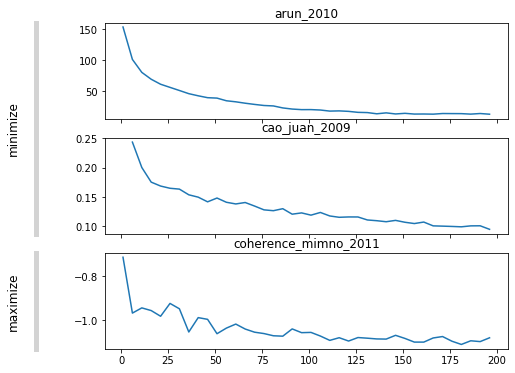

In [18]:
from tmtoolkit.topicmod.visualize import plot_eval_results

plot_eval_results(eval_results_by_ntopics);

These charts do not "elbow" as cleanly as we would like, but we will set the number of topics, `n_topics`, to about 30. We don't have to generate a model with these hyperparameters again, because it's already in the evaluation results (thanks to `return_models=True`). We extract the model from there in order to use it in the rest of the chapter.

In [19]:
best_k = 26
best_tm = [m for k, m in eval_results_by_ntopics if k == best_k][0]['model']
best_tm.n_topics, best_tm.alpha, best_tm.eta  # just to make sure

(26, 1e-26, 0.001)

## Visualize the topics

### Interactive visualization with pyLDAVis

The [pyLDAVis package](https://pyldavis.readthedocs.io/) offers a great interactive tool to explore a topic model. The tmtoolkit function [parameters_for_ldavis()](api.rst#tmtoolkit.topicmod.visualize.generate_wordclouds_for_document_topics) allows to prepare your topic model data for this package so that you can easily pass it on to pyLDAVis.

In [20]:
from tmtoolkit.topicmod.visualize import parameters_for_ldavis

ldavis_params = parameters_for_ldavis(best_tm.topic_word_,
                                      best_tm.doc_topic_,
                                      dtm,
                                      vocab)
try:
    import pyLDAvis
except ModuleNotFoundError:
    !pip install pyldavis
    import pyLDAvis

pyLDAvis.enable_notebook()
vis_data = pyLDAvis.prepare(**ldavis_params)
pyLDAvis.display(vis_data)

     |████████████████████████████████| 1.6MB 27.3MB/s eta 0:00:01
     |████████████████████████████████| 829kB 83.2MB/s eta 0:00:01
     |████████████████████████████████| 552kB 85.6MB/s eta 0:00:01
  Created wheel for pyldavis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=96445 sha256=13b48b6c0a26e0cc1c8fbad2b85cc7f24d2be8c715951e8e30e07b6da882bd36
  Stored in directory: /home/ec2-user/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for future: filename=future-0.18.2-cp36-none-any.whl size=491095 sha256=d2bf399f2fc4dd83b59edd71bbeb29b59571686cfe983e46b79fa26d722a5b79
  Stored in directory: /home/ec2-user/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32056 sha256=ce2d55dba5c1df940842c08f3e73e7c1dde039b8061fbd56857f3fc857255f7c
  Stored in directory: /home/ec2-user/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a

Writing Topics visualization to [topicsviz.html](topicsviz.html)

In [21]:
viz = pyLDAvis.prepared_data_to_html(vis_data)

with open('topicsviz.html', 'w') as vizfile:
    vizfile.write(viz)

### Generating labels for topics

In topic modeling, topics are numbered because they're *abstract* – they're simply a probability distribution across all words in the vocabulary. Still, it's useful to give them labels for better identification. The function [generate_topic_labels_from_top_words()](api.rst#tmtoolkit.topicmod.model_stats.generate_topic_labels_from_top_words) is very useful for that, as it finds labels according to the most "relevant" words in each topic. We'll later see how we can identify the most relevant words per topic using a special [relevance statistic](#Topic-word-relevance). Note that you can adjust the weight of the relevance measure for the ranking by using the parameter `lambda_` which is in range $[0, 1]$.

The function requires at least the topic-word and document-topic distributions from the model, the document lengths and the vocabulary. It then finds the minimum number of relevant words that uniquely label each topic. You can also use a fixed number for that minimum number with the parameter `n_words`.

In [22]:
from tmtoolkit.bow.bow_stats import doc_lengths
from tmtoolkit.topicmod.model_stats import generate_topic_labels_from_top_words

doc_lengths = doc_lengths(dtm)
topic_labels = generate_topic_labels_from_top_words(
    best_tm.topic_word_,
    best_tm.doc_topic_,
    doc_lengths,
    vocab,
    lambda_=0.6,
    n_words=3,
    labels_format='{topwords}'
)

topic_labels

array(['commissioner_attorney_county', 'school_student_support',
       'application_zone_applicant', 'permit_avenue_disable',
       'med_death_annuity', 'interior_historic_mechanical',
       'maintain_adjacent_premise', 'compliance_information_director',
       'health_hospital_thru', 'service_total_inc', 'tax_bond_project',
       'propose_plan_locate', 'housing_cha_resolution',
       'county_cook_whereas', 'contract_board_increase',
       'commissioner_preserve_forest', 'board_member_motion',
       'contractor_amendment_demolition', 'budget_victim_committee',
       'representation_respondent_minor', 'ave_residential_common',
       'attorney_payment_submit', 'quality_patient_health',
       'trustee_annuity_benefit', 'amount_reclamation_water',
       'get_go_think'], dtype='<U31')

As we can see, two words are necessary to label each topic uniquely. By default, each label is prefixed with a number. You can change that with the parameter `labels_format`.

Let's have a look at the top words for a specific topic. We can use [ldamodel_top_topic_words()](api.rst#tmtoolkit.topicmod.model_io.ldamodel_top_topic_words) for that from the module [topicmod.model_io](api.rst#module-tmtoolkit.topicmod.model_io), which we will have a closer look at [later](#Displaying-and-exporting-topic-modeling-results):

In [23]:
from tmtoolkit.topicmod.model_io import ldamodel_top_topic_words

top_topic_word = ldamodel_top_topic_words(best_tm.topic_word_,
                                          vocab,
                                          row_labels=topic_labels)
top_topic_word

,rank_1,rank_2,rank_3,rank_4,rank_5,rank_6,rank_7,rank_8,rank_9,rank_10
topic,,,,,,,,,,
commissioner_attorney_county,commissioner (0.04314),county (0.03629),attorney (0.02909),cook (0.02783),state (0.02119),case (0.01685),chairman (0.01655),motion (0.0163),subcommittee (0.01239),litigation (0.01191)
school_student_support,school (0.02978),support (0.023),community (0.0228),program (0.0174),student (0.01685),family (0.01297),serve (0.01052),include (0.01005),high (0.009534),year (0.009416)
application_zone_applicant,application (0.03833),zone (0.03662),applicant (0.03411),subject (0.02958),district (0.02919),owner (0.02805),premise (0.02448),affect (0.02422),foot (0.022),reduce (0.01876)
permit_avenue_disable,avenue (0.08037),permit (0.07612),street (0.05158),west (0.03694),disable (0.03534),park (0.03004),south (0.02915),north (0.02687),side (0.02436),zone (0.02388)
med_death_annuity,annuity (0.02314),employee (0.02308),update (0.01771),date (0.01635),death (0.01629),service (0.01552),hold (0.01535),med (0.01517),work (0.01378),disability (0.01321)
interior_historic_mechanical,work (0.0288),district (0.02668),interior (0.02553),permit (0.02373),historic (0.02283),new (0.02185),date (0.02119),mechanical (0.02023),exist (0.0196),exterior (0.01921)
maintain_adjacent_premise,public (0.06925),maintain (0.06699),premise (0.05613),adjacent (0.05554),know (0.04146),avenue (0.03421),locate (0.03316),street (0.03239),north (0.03017),west (0.02738)
compliance_information_director,county (0.02254),committee (0.01541),director (0.01408),cook (0.0139),compliance (0.01362),report (0.01278),information (0.01177),provide (0.01163),program (0.01096),page (0.01025)
health_hospital_thru,health (0.0439),cook (0.02647),contract (0.02506),county (0.02468),service (0.02302),hospital (0.02154),request (0.01778),care (0.01509),page (0.01497),system (0.0144)


### Marginal topic and word distributions

We'll now focus on the marginal topic and word distributions. Let's get the marginal topic distribution first by using [marginal_topic_distrib()](api.rst#tmtoolkit.topicmod.model_stats.marginal_topic_distrib):

In [24]:
from tmtoolkit.topicmod.model_stats import marginal_topic_distrib

marg_topic = marginal_topic_distrib(best_tm.doc_topic_, doc_lengths)
marg_topic

array([0.02731, 0.02652, 0.03818, 0.02698, 0.02388, 0.0521 , 0.02281,
       0.05652, 0.04591, 0.0332 , 0.03404, 0.0276 , 0.06764, 0.03809,
       0.04253, 0.05809, 0.04498, 0.03158, 0.0406 , 0.03856, 0.02744,
       0.03933, 0.0274 , 0.02757, 0.05101, 0.05013])

The marginal topic distribution can be interpreted as the "importance" of each topic for the whole corpus. Let's get the sorted indices into `topic_labels` with `np.argsort()` and get the top ten topics:

In [25]:
# np.argsort() gives ascending order, hence reverse via [::-1]
topic_labels[np.argsort(marg_topic)[::-1][:10]]

array(['housing_cha_resolution', 'commissioner_preserve_forest',
       'compliance_information_director', 'interior_historic_mechanical',
       'amount_reclamation_water', 'get_go_think', 'health_hospital_thru',
       'board_member_motion', 'contract_board_increase',
       'budget_victim_committee'], dtype='<U31')

Likewise, we can get the marginal word distribution with [marginal_word_distrib()](api.rst#tmtoolkit.topicmod.model_stats.marginal_word_distrib) from the model's topic-word distribution and the marginal topic distribution. We'll use this to list the most probable words for the corpus. As expected, these are mostly quite common words:

In [26]:
from tmtoolkit.topicmod.model_stats import marginal_word_distrib

marg_word = marginal_word_distrib(best_tm.topic_word_, marg_topic)
vocab[np.argsort(marg_word)[::-1][:10]]

array(['board', 'county', 'commissioner', 'service', 'district',
       'chicago', 'cook', 'contract', 'meeting', 'approve'], dtype='<U19')

Two helper functions exist for this purpose: [most_probable_words()](api.rst#tmtoolkit.topicmod.model_stats.most_probable_words) and [least_probable_words()](api.rst#tmtoolkit.topicmod.model_stats.least_probable_words) sort the vocabulary according to the marginal probability:

In [27]:
from tmtoolkit.topicmod.model_stats import most_probable_words, least_probable_words

most_probable_words(vocab, best_tm.topic_word_,
                    best_tm.doc_topic_, doc_lengths,
                    n=10)

array(['board', 'county', 'commissioner', 'service', 'district',
       'chicago', 'cook', 'contract', 'meeting', 'approve'], dtype='<U19')

In [28]:
least_probable_words(vocab, best_tm.topic_word_,
                     best_tm.doc_topic_, doc_lengths,
                     n=10)

array(['wells', '61st', 'elsewhere', 'afforded', 'asking', 'votes',
       'joined', 'interviewed', 'rising', 'pieces'], dtype='<U19')

### Word distinctiveness and saliency

Word *distinctiveness* and *saliency* (see below) help to identify the most "informative" words in a corpus given its topic model. Both measures are introduced in [Chuang et al. 2012](https://dl.acm.org/citation.cfm?id=2254572).

Word distinctiveness is calculated for each word $w$ as

$\text{distinctiveness}(w) = \sum_T(P(T|w) \log \frac{P(T|w)}{P(T)})$.

where $P(T)$ is the marginal topic distribution and $P(T|w)$ is the probability of a topic given a word $w$.

We can calculate this measure using [word_distinctiveness()](api.rst#tmtoolkit.topicmod.model_stats.word_distinctiveness). To use this measure directly to rank words, we can use [most_distinct_words()](api.rst#tmtoolkit.topicmod.model_stats.most_distinct_words) and [least_distinct_words()](api.rst#tmtoolkit.topicmod.model_stats.least_distinct_words):

In [29]:
from tmtoolkit.topicmod.model_stats import word_distinctiveness, \
    most_distinct_words, least_distinct_words

word_distinct = word_distinctiveness(best_tm.topic_word_, marg_topic)
word_distinct[:10]   # first 10 words in vocab

array([2.7951 , 2.95694, 2.06683, 3.01145, 2.83605, 2.52483, 3.19419,
       2.87717, 2.89353, 3.06541])

In [30]:
most_distinct_words(vocab, best_tm.topic_word_,
                    best_tm.doc_topic_, doc_lengths,
                    n=10)

array(['ingres', 'cafe', 'alleys', 'eff', 'reversionary', 'workman',
       'adj', 'lra', 'wkr', 'prerequisite'], dtype='<U19')

In [31]:
least_distinct_words(vocab, best_tm.topic_word_,
                     best_tm.doc_topic_, doc_lengths,
                     n=10)

array(['chicago', 'meet', 'provide', 'approve', 'department', 'september',
       'meeting', 'november', 'committee', 'report'], dtype='<U19')

Word *saliency* weights each words' distinctiveness by it's marginal probability $P(w)$:

$\text{saliency}(w) = P(w) \cdot \text{distinctiveness}(w)$.

The respective functions in tmtoolkit are [word_saliency()](api.rst#tmtoolkit.topicmod.model_stats.word_saliency), [most_salient_words()](api.rst#tmtoolkit.topicmod.model_stats.most_salient_words) and [least_salient_words()](api.rst#tmtoolkit.topicmod.model_stats.least_salient_words):

In [32]:
from tmtoolkit.topicmod.model_stats import word_saliency, \
    most_salient_words, least_salient_words

word_sal = word_saliency(best_tm.topic_word_, best_tm.doc_topic_, doc_lengths)
word_sal[:10]   # first 10 words in vocab

array([1.31527e-05, 1.08308e-05, 2.15787e-05, 1.73099e-05, 2.99563e-06,
       3.98316e-06, 1.70855e-06, 4.53910e-06, 4.56465e-06, 4.83570e-06])

In [33]:
most_salient_words(vocab, best_tm.topic_word_,
                   best_tm.doc_topic_, doc_lengths,
                   n=30)

array(['county', 'attorney', 'avenue', 'board', 'permit', 'commissioner',
       'contract', 'representation', 'cook', 'respondent', 'health',
       'minor', 'district', 'case', 'public', 'premise', 'street',
       'service', 'order', 'fee', 'indigent', 'maintain', 'payment',
       'submit', 'zone', 'amount', 'west', 'applicant', 'motion',
       'adjacent'], dtype='<U19')

In [34]:
least_salient_words(vocab, best_tm.topic_word_,
                    best_tm.doc_topic_, doc_lengths,
                    n=30)

array(['neighborhoods', 'referenced', 'paragraphs', 'varying',
       'principals', 'landscaped', 'completed', 'hosted', 'flats',
       'porches', 'later', 'scored', 'developers', 'camping',
       'commencing', 'urging', 'subcontracting', 'waterways', 'awaiting',
       'venues', 'procurements', 'preserves', 'tendered', 'concurrences',
       '1st', 'appurtenances', 'renewed', 'named', 'handled', 'erika'],
      dtype='<U19')

### Topic-word relevance

The topic-word relevance measure as introduced by [Sievert and Shirley 2014](https://www.aclweb.org/anthology/W14-3110/) helps to identify the most relevant words within a topic by also accounting for the marginal probability of each word across the corpus. This is done by integrating a *lift* value, which is the "ratio of a term's probability within a topic to its marginal probability across the corpus." (ibid.)

Thus for each word $w$, given a topic-word distribution $\phi$, a topic $t$ and a weight parameter $\lambda$, it is calculated as:

$\text{relevance}_{\phi, \lambda}(w, t) = \lambda \log \phi_{t,w} + (1-\lambda) \log \frac{\phi_{t,w}}{p(w)}$.

The first term $\log \phi_{t,w}$ is the log of the topic-word distribution, the second term $\log \frac{\phi_{t,w}}{p(w)}$ is the *log lift* and $\lambda$ can be used to control the weight between both terms. The lower $\lambda$, the more weight is put on the lift term, i.e. the more different are the results from the original topic-word distribution.

This measure is implemented in [topic_word_relevance()](api.rst#tmtoolkit.topicmod.model_stats.topic_word_relevance). It returns a matrix of the same shape as the topic-word distribution, i.e. each row represents a topic with a (log-transformed) distribution across all words in the vocabulary. Please note that the lambda parameter ends with an underscore: `lambda_`.

In [35]:
from tmtoolkit.topicmod.model_stats import topic_word_relevance

topic_word_rel = topic_word_relevance(best_tm.topic_word_, best_tm.doc_topic_,
                                      doc_lengths, lambda_=0.6)
topic_word_rel

array([[-12.8675 , -12.76729, -13.18627, ..., -13.69269, -13.54441,
        -13.79193],
       [-12.83805, -12.73785, -13.15683, ..., -13.66324, -13.51497,
        -13.76248],
       [-13.2025 ,  -5.5009 , -13.52128, ..., -14.02769, -13.87942,
        -14.12693],
       ...,
       [-12.87679, -12.77658, -13.19556, ..., -13.70198, -13.5537 ,
        -13.80122],
       [-13.49218, -13.39197, -13.81095, ..., -14.31737, -14.16909,
        -14.41661],
       [-13.47485, -13.37464,  -4.48788, ...,  -6.29334, -14.15176,
        -14.39928]])

To confirm that it's 26 topics across all words in the vocabulary:

In [36]:
topic_word_rel.shape

(26, 7503)

Two functions can be used to get the most or least relevant words for a topic: [most_relevant_words_for_topic()](api.rst#tmtoolkit.topicmod.model_stats.most_relevant_words_for_topic) and [least_relevant_words_for_topic()](api.rst#tmtoolkit.topicmod.model_stats.least_relevant_words_for_topic). You can select the topic with the `topic` parameter which is a **zero-based topic index**.

We'll do it for topic with index 4, which is:

In [37]:
topic_labels[4]

'med_death_annuity'

In [38]:
from tmtoolkit.topicmod.model_stats import most_relevant_words_for_topic, \
    least_relevant_words_for_topic

most_relevant_words_for_topic(vocab, topic_word_rel, topic=4, n=10)

array(['med', 'death', 'annuity', 'employee', 'update', 're', 'marry',
       'inv', 'disability', 'hold'], dtype='<U19')

In [39]:
for i in range(26):
    print(topic_labels[i])
    print(' '.join(most_relevant_words_for_topic(vocab, topic_word_rel, topic=i, n=20)))
    print()

commissioner_attorney_county
commissioner attorney county cook litigation subcommittee dean state chairman silvestri civil vice collins suffredin expense carry case tobolski schneider motion

school_student_support
school student support community transition serve high family program grade parent cooper cps education focus offer life academic january opportunity

application_zone_applicant
application zone applicant affect subject owner setback variation reduce toia premise foot district rear residence sercye yard flores ward use

permit_avenue_disable
permit avenue disable street west south point side disabled park foot north thereof zone repeal load ward east amend tow

med_death_annuity
med death annuity employee update re marry inv disability hold eff note monthly spouse annuitant ordinary municipal reversionary asst error

interior_historic_mechanical
interior historic mechanical exterior work electrical stamp window exist permit new district landmark date match preservation repla

In [40]:
least_relevant_words_for_topic(vocab, topic_word_rel, topic=4, n=10)

array(['board', 'county', 'commissioner', 'district', 'cook', 'contract',
       'approve', 'motion', 'avenue', 'attorney'], dtype='<U19')

### Topic coherence

We already used the *coherence* metric ([Mimno et al. 2011](https://dl.acm.org/citation.cfm?id=2145462)) for topic model evaluation. However, this metric cannot only be used to assess the overall quality of a topic model, but also to evaluate the individual topics' coherence.

In [41]:
from tmtoolkit.topicmod.evaluate import metric_coherence_mimno_2011

# use top 20 words per topic for metric
coh = metric_coherence_mimno_2011(best_tm.topic_word_, dtm, top_n=20)
coh

array([-0.80555, -0.72153, -0.99879, -1.31452, -1.25409, -1.26732,
       -1.51853, -0.80316, -0.87214, -0.71452, -0.78188, -0.84375,
       -0.60583, -1.03974, -0.61386, -0.94632, -0.96036, -0.84885,
       -0.56195, -1.10554, -0.96257, -0.84218, -1.41654, -0.82912,
       -0.62568, -0.74317])

This generates a coherence value for each topic. Let's show the distribution of these values:

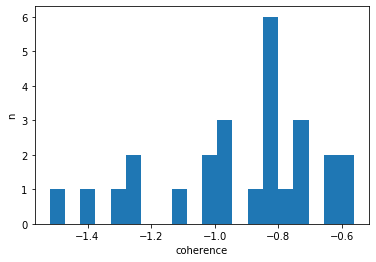

In [42]:
import matplotlib.pyplot as plt

plt.hist(coh, bins=20)
plt.xlabel('coherence')
plt.ylabel('n')
plt.show();

And print the best and worst topics according to this metric:

In [43]:
import numpy as np

top10_t_indices = np.argsort(coh)[::-1][:5]
bottom10_t_indices = np.argsort(coh)[:5]

topic_labels[top10_t_indices]

array(['budget_victim_committee', 'housing_cha_resolution',
       'contract_board_increase', 'amount_reclamation_water',
       'service_total_inc'], dtype='<U31')

In [44]:
topic_labels[bottom10_t_indices]

array(['maintain_adjacent_premise', 'quality_patient_health',
       'permit_avenue_disable', 'interior_historic_mechanical',
       'med_death_annuity'], dtype='<U31')

More coherence metrics can be used with the function [metric_coherence_gensim()](api.rst#tmtoolkit.topicmod.evaluate.metric_coherence_gensim). This requires that [gensim](https://radimrehurek.com/gensim/) is installed. Furthemore, most metrics require that a parameter `texts` is passed which is the tokenized text that was used to create the document-term matrix.

### Filtering topics

With the function [filter_topics()](api.rst#tmtoolkit.topicmod.model_stats.filter_topics), you can filter the topics according to their topic-word distribution and the following search criteria:

- `search_pattern`: one or more search patterns according to the [common parameters for pattern matching](preprocessing.ipynb#Common-parameters-for-pattern-matching-functions)
- `top_n`: pattern match(es) must occur in the first `top_n` most probable words in the topic
- `thresh`: matched words' probability must be above this threshold

You must specify at least one of `top_n` and `thresh`, but you can also specify both. The function returns an array of topic indices (which start with zero!).

Let's find all topics that have the word "police" in the top 5 most probable words:

In [45]:
from tmtoolkit.topicmod.model_stats import filter_topics

found_topics = filter_topics('finance', vocab,
                             best_tm.topic_word_, top_n=5)
found_topics

array([], dtype=int64)

We can use these indices with our `topic_labels`:

In [46]:
topic_labels[found_topics]

array([], dtype='<U31')

Next, we want to select all topics where *any* of the words matched by the glob patterns (`match_type='glob'`) `"trump"` *or* `"russia*"` achieve at least a probability of 0.01 (`thresh=0.01`):

In [47]:
found_topics = filter_topics(['finance', 'contract*'], vocab,
                             best_tm.topic_word_, thresh=0.01, match_type='glob')
topic_labels[found_topics]

array(['commissioner_attorney_county', 'health_hospital_thru',
       'housing_cha_resolution', 'contract_board_increase',
       'contractor_amendment_demolition', 'attorney_payment_submit'],
      dtype='<U31')

When we specify `cond='all'`, *all* patterns must have at least one match (here in the top 50 list of words per topic):

In [48]:
found_topics = filter_topics(['finance', 'contract*'], vocab,
                             best_tm.topic_word_, top_n=50, match_type='glob',
                             cond='all')
topic_labels[found_topics]

array(['health_hospital_thru', 'attorney_payment_submit'], dtype='<U31')

### Excluding topics

It is often the case that some topics of a topic model rank a lot of uninformative (e.g. very common) words the highest. This results in some uninformative topics, which you may want to exclude from further analysis. Note that if a large fraction of topics seems uninformative, it points to a problem with your topic model and/or your preprocessing steps. You should [evaluate](#Evaluation-of-topic-models) your candidate models carefully with the mentioned metrics and/or adjust your text preprocessing pipeline.

The function [exclude_topics()](api.rst#tmtoolkit.topicmod.model_stats.exclude_topics) allows to remove a specified set of topics from the document-topic and topic-word distributions. You need to pass the **zero-based** indices of the topics that you want to remove, and both distributions.

In this example, I identified the following topics as uninformative (by looking at the top ranked words either by topic-word distribution or topic-word relevance):

In [49]:
topic_labels[bottom10_t_indices]

array(['maintain_adjacent_premise', 'quality_patient_health',
       'permit_avenue_disable', 'interior_historic_mechanical',
       'med_death_annuity'], dtype='<U31')

We can now pass these indices to [exclude_topics()](api.rst#tmtoolkit.topicmod.model_stats.exclude_topics) along with the topic model distributions. We'll get back new, filtered, distributions.

In [50]:
#from tmtoolkit.topicmod.model_stats import exclude_topics

#new_doc_topic, new_topic_word, new_topic_mapping = \
#    exclude_topics(uninform_topics, best_tm.doc_topic_,
#                best_tm.topic_word_, return_new_topic_mapping=True)
#new_doc_topic.shape, new_topic_word.shape

We can see in the new distributions' shapes that we now have 45 instead of 50 topics, because we removed five of them. We shouldn't forget to also update the topic labels and remove the unwanted topics:

In [51]:
#new_topic_labels = np.delete(topic_labels, uninform_topics)
#new_topic_labels

NameError: name 'uninform_topics' is not defined

## Displaying topic modeling results

The [topicmod.model_io](api.rst#module-tmtoolkit.topicmod.model_io) module provides several functions for displaying and exporting topic modeling results, i.e. results derived from the document-topic and topic-word distribution of a given topic model.

We already used [ldamodel_top_topic_words()](api.rst#tmtoolkit.topicmod.model_io.ldamodel_top_topic_words) briefly, which generates a dataframe with the top words from a topic-word distribution. You can also use the topic-word relevance matrix instead. With `top_n` we can control the number of top words:

In [53]:
# using relevance matrix here
ldamodel_top_topic_words(topic_word_rel, vocab, top_n=5)

,rank_1,rank_2,rank_3,rank_4,rank_5
topic,,,,,
topic_1,commissioner (-1.204),attorney (-1.347),county (-1.404),cook (-1.542),litigation (-1.545)
topic_2,school (-0.766),student (-1.007),support (-1.112),community (-1.289),transition (-1.526)
topic_3,application (-0.8626),zone (-0.8824),applicant (-0.9615),affect (-0.9791),subject (-1.038)
topic_4,permit (-0.322),avenue (-0.3345),disable (-0.5672),street (-0.7733),west (-0.9179)
topic_5,med (-1.026),death (-1.044),annuity (-1.121),employee (-1.254),update (-1.263)
topic_6,interior (-1.044),historic (-1.095),mechanical (-1.177),exterior (-1.196),work (-1.261)
topic_7,maintain (-0.1731),adjacent (-0.2624),premise (-0.4404),public (-0.5506),know (-0.5768)
topic_8,compliance (-1.602),information (-1.775),director (-1.831),resource (-1.841),county (-1.88)
topic_9,health (-0.9059),hospital (-1.323),thru (-1.496),cook (-1.592),care (-1.609)


Note that the values in parantheses are the corresponding values from the matrix for that word in that topic. They're negative because of the log transformation that is applied in the topic-word relevance measure.

A similar function can be used for the document-topic distribution: [ldamodel_top_doc_topics()](api.rst#tmtoolkit.topicmod.model_io.ldamodel_top_doc_topics). Here, `top_n` controls the number of top-ranked topics to export. This time, we use the filtered document-topic distribution `new_doc_topics`:

In [54]:
from tmtoolkit.topicmod.model_io import ldamodel_top_doc_topics

ldamodel_top_doc_topics(best_tm.doc_topic_, doc_labels, top_n=3,
                        topic_labels=topic_labels)[:5]

,rank_1,rank_2,rank_3
document,,,
5015774-Minutes,get_go_think (0.03846),amount_reclamation_water (0.03846),school_student_support (0.03846)
5015821-Agenda,budget_victim_committee (0.3032),tax_bond_project (0.2014),contractor_amendment_demolition (0.1629)
5015824-Agenda,compliance_information_director (0.2475),contract_board_increase (0.2355),tax_bond_project (0.1916)
5015859-Committee-on-Finance-Audit-amp-Budget-2018-10-10,service_total_inc (0.3149),housing_cha_resolution (0.2553),budget_victim_committee (0.1362)
5015860-Regular-Commission-Meeting-2018-08-23-Minutes,service_total_inc (0.3196),get_go_think (0.2244),budget_victim_committee (0.1472)


Let's have a look at one of these documents:

In [59]:
doc_topics = ldamodel_top_doc_topics(best_tm.doc_topic_, doc_labels, top_n=3,
                        topic_labels=topic_labels)

In [66]:
doc_frames = {}
for label in topic_labels:
    doc_frames[label] = doc_topics.loc[doc_topics.rank_1.str.startswith(label)]

In [82]:
import shutil

TOPICSDIR = '../../data/documenters/topics'

for label, frame in doc_frames.items():
    with open(os.path.join(TOPICSDIR, '%s.txt' % label), 'w') as docfile:
        for doc in frame.index:
            docfile.write(doc)
            docfile.write('\n')
            os.makedirs(os.path.join(TOPICSDIR, label), exist_ok=True)
            shutil.copyfile(os.path.join(DATADIR, '%s.txt' % doc), os.path.join(TOPICSDIR, label, '%s.txt' %  doc))

In [105]:
DOCCLOUD_ROOT = 'https://www.documentcloud.org/documents/'

with open('topics.html', 'w') as topicindex:
    for label, frame in doc_frames.items():
        topicindex.write(f'<h3>{label}</h3>')
        topicindex.write('<ul>')
        for doc in frame.index:
            topicindex.write(f'<li><a href="{DOCCLOUD_ROOT}{doc}.html" target="_blank">{doc}</a></li>')
            topicindex.write('\n')
        topicindex.write('</ul>')

In [75]:
!pip install "textdistance[Hamming]"

     |████████████████████████████████| 51kB 8.1MB/s  eta 0:00:01
     |████████████████████████████████| 184kB 24.8MB/s eta 0:00:01
     |████████████████████████████████| 890kB 16.4MB/s eta 0:00:01
     |████████████████████████████████| 143kB 88.2MB/s eta 0:00:01
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.0-cp36-cp36m-linux_x86_64.whl size=144492 sha256=5c1e6a1d6b6c6f2af7ff786d5cc4ff1922df27afc838f6f1703748e4af195fe6
  Stored in directory: /home/ec2-user/.cache/pip/wheels/de/c2/93/660fd5f7559049268ad2dc6d81c4e39e9e36518766eaf7e342
  Created wheel for distance: filename=Distance-0.1.3-cp36-none-any.whl size=8849 sha256=f119aa86bc896a1fb5060758acabd858df23f26ace930c22a739dab27c46de40
  Stored in directory: /home/ec2-user/.cache/pip/wheels/d5/aa/e1/dbba9e7b6d397d645d0f12db1c66dbae9c5442b39b001db18e
  Created wheel for jellyfish: filename=jellyfish-0.7.2-cp36-cp36m-linux_x86_64.whl size=59662 sha256=9a5979c2f5bfab8236c06420ee21177f56192d8ac0c0923a4b14990297

In [78]:
import textdistance

similarities = []
for label, frame in doc_frames.items():
    docs = [doc for doc in frame.index]
    similarities.append( (textdistance.hamming.normalized_similarity(*docs), label) )

In [80]:
for score, label in sorted(similarities):
    print('{:f}'.format(score), label)

0.017241 board_member_motion
0.017241 budget_victim_committee
0.017241 compliance_information_director
0.017241 contractor_amendment_demolition
0.017241 get_go_think
0.017241 housing_cha_resolution
0.017241 interior_historic_mechanical
0.017241 tax_bond_project
0.017544 commissioner_attorney_county
0.017544 commissioner_preserve_forest
0.017544 contract_board_increase
0.017544 trustee_annuity_benefit
0.017857 amount_reclamation_water
0.017857 county_cook_whereas
0.017857 health_hospital_thru
0.017857 propose_plan_locate
0.017857 quality_patient_health
0.017857 school_student_support
0.017857 service_total_inc
0.018182 ave_residential_common
0.018519 application_zone_applicant
0.018519 med_death_annuity
0.035714 attorney_payment_submit
0.035714 maintain_adjacent_premise
0.035714 permit_avenue_disable
0.821429 representation_respondent_minor


There are also two functions that generate datatables for the full topic-word and document-topic distributions: [ldamodel_full_topic_words()](api.rst#tmtoolkit.topicmod.model_io.ldamodel_full_topic_words) and [ldamodel_full_doc_topics()](api.rst#tmtoolkit.topicmod.model_io.ldamodel_full_doc_topics). The output of both functions is naturally quite big, as long as you're not working with a "toy dataset".

In [83]:
from tmtoolkit.topicmod.model_io import ldamodel_full_topic_words

datatable_topic_word = ldamodel_full_topic_words(best_tm.topic_word_,
                                                 vocab,
                                                 row_labels=topic_labels)
# displaying only the first 5 topics with the first
# 10 words from the vocabulary (which are all numbers)
#datatable_topic_word[:5, :10]
datatable_topic_word[:5]

,_topic,100th,107th,10th,115th,125th,127th,134th,135th,13th,...,zero,zimmerman,zip,zone,zoned,zones,zoning,zoo,zoological,zopp
0,commissioner_attorney_county,1.908816e-08,1.908816e-08,1.908816e-08,1.908816e-08,1.908816e-08,1.908816e-08,1.908816e-08,1.908816e-08,1.908816e-08,...,1.908816e-08,1.908816e-08,1.908816e-08,1.908816e-08,1.908816e-08,1.908816e-08,1.908816e-08,1.908816e-08,1.908816e-08,1.908816e-08
1,school_student_support,1.965853e-08,1.965853e-08,1.965853e-08,1.965853e-08,1.965853e-08,1.965853e-08,1.965853e-08,1.965853e-08,1.965853e-08,...,1.965853e-08,1.965853e-08,1.965853e-08,1.965853e-08,7.865378e-05,1.965853e-08,1.965853e-08,1.965853e-08,1.965853e-08,1.965853e-08
2,application_zone_applicant,1.365439e-08,2.732244e-05,1.365439e-08,1.365439e-08,1.365439e-08,2.732244e-05,1.365439e-08,1.365439e-08,1.365439e-08,...,1.365439e-08,1.365439e-08,1.365439e-08,3.662110e-02,1.365439e-08,1.365439e-08,1.365439e-08,1.365439e-08,1.365439e-08,1.365439e-08
3,permit_avenue_disable,9.661994e-05,1.932012e-08,1.932012e-08,1.932012e-08,1.932012e-08,1.932012e-08,1.932012e-08,1.932012e-08,3.865957e-05,...,1.932012e-08,1.932012e-08,1.932012e-08,2.387969e-02,1.932012e-08,1.933944e-05,1.932206e-04,1.932012e-08,1.932012e-08,1.932012e-08
4,med_death_annuity,2.183191e-08,2.183191e-08,2.185375e-05,2.183191e-08,2.183191e-08,2.183191e-08,2.183191e-08,2.183191e-08,2.183191e-08,...,2.183191e-08,2.183191e-08,2.183191e-08,1.091814e-04,2.183191e-08,2.183191e-08,2.183191e-08,2.183191e-08,2.183191e-08,2.183191e-08


In [84]:
from tmtoolkit.topicmod.model_io import ldamodel_full_doc_topics

datatable_doc_topic = ldamodel_full_doc_topics(best_tm.doc_topic_,
                                               doc_labels,
                                               topic_labels=topic_labels)
# displaying only the first 3 documents with the first
# 5 topics
#datatable_doc_topic[:3, :5]
datatable_doc_topic[:3]

,_doc,commissioner_attorney_county,school_student_support,application_zone_applicant,permit_avenue_disable,med_death_annuity,interior_historic_mechanical,maintain_adjacent_premise,compliance_information_director,health_hospital_thru,...,board_member_motion,contractor_amendment_demolition,budget_victim_committee,representation_respondent_minor,ave_residential_common,attorney_payment_submit,quality_patient_health,trustee_annuity_benefit,amount_reclamation_water,get_go_think
0,5015774-Minutes,3.846154e-02,3.846154e-02,3.846154e-02,3.846154e-02,3.846154e-02,3.846154e-02,3.846154e-02,0.038462,3.846154e-02,...,3.846154e-02,0.038462,3.846154e-02,3.846154e-02,3.846154e-02,3.846154e-02,3.846154e-02,3.846154e-02,3.846154e-02,3.846154e-02
1,5015821-Agenda,2.262443e-29,2.262443e-29,2.262443e-29,2.262443e-29,2.262443e-29,2.262443e-29,2.262443e-29,0.162896,1.153846e-01,...,5.429864e-02,0.162896,3.031674e-01,2.262443e-29,2.262443e-29,2.262443e-29,2.262443e-29,2.262443e-29,2.262443e-29,2.262443e-29
2,5015824-Agenda,1.996008e-29,2.994012e-02,1.996008e-29,1.996008e-29,1.996008e-29,9.980040e-03,1.996008e-29,0.247505,1.996008e-29,...,1.996008e-29,0.167665,1.996008e-29,1.996008e-29,1.996008e-29,1.996008e-29,1.996008e-29,1.996008e-29,1.996008e-29,1.197605e-02


For quick inspection of topics there's also a pair of print functions. We already used [print_ldamodel_topic_words()](api.rst#tmtoolkit.topicmod.model_io.print_ldamodel_topic_words), but we haven't tried [print_ldamodel_doc_topics()](api.rst#tmtoolkit.topicmod.model_io.print_ldamodel_doc_topics) yet. This prints the `top_n` most probable topics for each document:

In [85]:
from tmtoolkit.topicmod.model_io import print_ldamodel_doc_topics

# subsetting new_doc_topic and doc_labels to get only the first
# five documents
print_ldamodel_doc_topics(best_tm.doc_topic_[:5, :], doc_labels[:5],
                          val_labels=topic_labels)

5015774-Minutes
> #1. get_go_think (0.038462)
> #2. amount_reclamation_water (0.038462)
> #3. school_student_support (0.038462)
5015821-Agenda
> #1. budget_victim_committee (0.303167)
> #2. tax_bond_project (0.201357)
> #3. contractor_amendment_demolition (0.162896)
5015824-Agenda
> #1. compliance_information_director (0.247505)
> #2. contract_board_increase (0.235529)
> #3. tax_bond_project (0.191617)
5015859-Committee-on-Finance-Audit-amp-Budget-2018-10-10
> #1. service_total_inc (0.314894)
> #2. housing_cha_resolution (0.255319)
> #3. budget_victim_committee (0.136170)
5015860-Regular-Commission-Meeting-2018-08-23-Minutes
> #1. service_total_inc (0.319569)
> #2. get_go_think (0.224417)
> #3. budget_victim_committee (0.147217)


## Visualizing topic models

The [topicmod.visualize](api.rst#visualize-topic-models-and-topic-model-evaluation-results) module contains several functions to visualize topic models and evaluation results. We've already used [plot_eval_results()](api.rst#tmtoolkit.topicmod.visualize.plot_eval_results) during [topic model evaluation](#Evaluation-of-topic-models) so we'll now focus on visualizing topic models.

### Heatmaps

Let's start with heatmap visualizations of document-topic or topic-word distributions from our topic model. This can be done with [plot_doc_topic_heatmap()](api.rst#tmtoolkit.topicmod.visualize.plot_doc_topic_heatmap) and [plot_topic_word_heatmap()](api.rst#tmtoolkit.topicmod.visualize.plot_topic_word_heatmap) respectively. Both functions draw on a [matplotlib](https://matplotlib.org/) figure and *Axes* object, which you must create before using these functions.

Heatmap visualizations essentially shade cells in a 2D matrix (like the document-topic or topic-word distributions) according to their value, i.e. the respective probability for a topic in a given document or a word in a given topic. Since these matrices are usually quite large, i.e. with hundreds of rows and/or columns, it doesn't make sense to plot a heatmap of the whole matrix, but rather a certain subset of interest. When we want to visualize a document-topic distribution, we can optionally select a subset of the documents with the `which_documents` parameter and a subset of the topics with the `which_topics` parameter. Let's draw a heatmap of a subset of documents across all topics at first:

In [99]:
import matplotlib.pyplot as plt
from tmtoolkit.topicmod.visualize import plot_doc_topic_heatmap

which_docs = list(corpus.keys())[:20]
which_topics = [label for score, label in sorted(similarities)][:10]

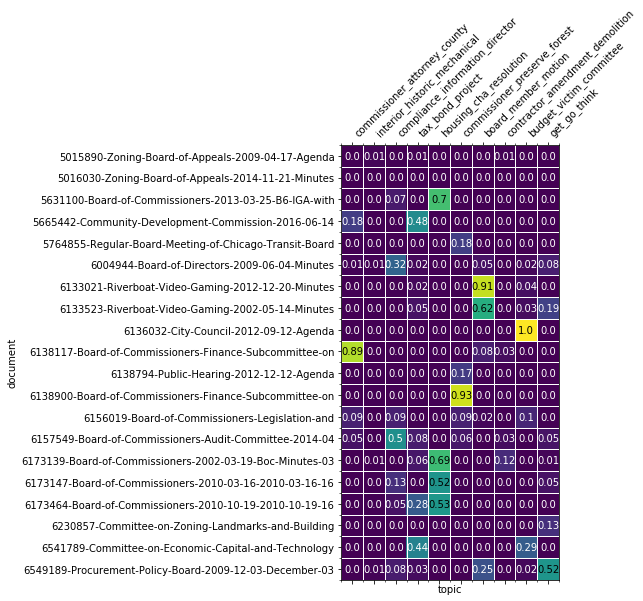

In [100]:
fig, ax = plt.subplots(figsize=(6, 8))



plot_doc_topic_heatmap(fig, ax, best_tm.doc_topic_, doc_labels,
                       topic_labels=topic_labels,
                       which_documents=which_docs,
                       which_topics=which_topics);

Similarily, we can work with [plot_topic_word_heatmap()](api.rst#tmtoolkit.topicmod.visualize.plot_topic_word_heatmap) to visualize a topic-word distribution. We can also select a subset of topics and words from the vocabulary:

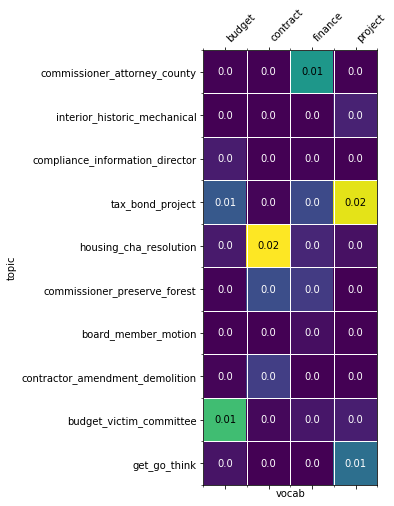

In [101]:
from tmtoolkit.topicmod.visualize import plot_topic_word_heatmap

fig, ax = plt.subplots(figsize=(12, 8))

which_words = ['finance', 'budget', 'project', 'contract']

plot_topic_word_heatmap(fig, ax, best_tm.topic_word_, vocab,
                        topic_labels=topic_labels,
                        which_topics=which_topics,
                        which_words=which_words);

Note that there's also a generic heatmap plotting function [plot_heatmap()](api.rst#plot-heatmaps-for-topic-models) for any kind of 2D matrices. 